In [39]:
#
## 2. Data Processing & Feature Engineering (`src/data_processing.py`)

### Purpose

#Turn raw transactions into **customer-level, model-ready features**.

### Key Ideas

"* Fail early if data is broken "
"One function = one responsibility No hard-coded magic"

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

RAW_PATH = Path(r"c:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\data\raw\CreditRisk-data.csv")
PROCESSED_PATH = Path(r"C:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\data\process\processed.csv")


def load_data(path: Path) -> pd.DataFrame:
    """Safely load raw transaction data."""
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    df = pd.read_csv(path, parse_dates=["TransactionStartTime"])

    if df.empty:
        raise ValueError("Loaded dataset is empty")

    return df


def create_aggregates(df: pd.DataFrame) -> pd.DataFrame:
    """Create customer-level aggregate features."""
    try:
        agg = df.groupby("CustomerId").agg(
            total_amount=("Amount", "sum"),
            avg_amount=("Amount", "mean"),
            txn_count=("TransactionId", "count"),
            amount_std=("Amount", "std"),
        ).reset_index()
    except KeyError as e:
        raise KeyError(f"Missing required column: {e}")

    agg["amount_std"] = agg["amount_std"].fillna(0)
    return agg


def extract_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """Extract time-based behavioral features."""
    df = df.copy()
    ts = df["TransactionStartTime"]

    df["txn_hour"] = ts.dt.hour
    df["txn_day"] = ts.dt.day
    df["txn_month"] = ts.dt.month
    df["txn_year"] = ts.dt.year

    return df


def build_features() -> pd.DataFrame:
    """End-to-end feature generation."""
    df = load_data(RAW_PATH)
    df = extract_time_features(df)

    agg = create_aggregates(df)

    final_df = pd.merge(df, agg, on="CustomerId", how="left")

    final_df.to_csv(PROCESSED_PATH, index=False)
    return final_df


if __name__ == "__main__":
    build_features()





In [40]:
#Feature Engineering (Customer-Level)
#We aggregate transactions into customer behavior.
def create_customer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create customer-level behavioral features"""

    customer_agg = (
        df.groupby("CustomerId")
        .agg(
            total_amount=("Amount", "sum"),
            avg_amount=("Amount", "mean"),
            txn_count=("TransactionId", "count"),
            amount_std=("Amount", "std"),
            fraud_txn_count=("FraudResult", "sum"),
            avg_value=("Value", "mean")
        )
        .reset_index()
    )

    customer_agg["amount_std"] = customer_agg["amount_std"].fillna(0)

    return customer_agg


In [41]:
#Time Behavior Features
def extract_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["txn_hour"] = df["TransactionStartTime"].dt.hour
    df["txn_day"] = df["TransactionStartTime"].dt.day
    df["txn_month"] = df["TransactionStartTime"].dt.month

    return (
        df.groupby("CustomerId")
        .agg(
            avg_txn_hour=("txn_hour", "mean"),
            avg_txn_day=("txn_day", "mean"),
            active_months=("txn_month", "nunique")
        )
        .reset_index()
    )


In [42]:
## 3. Proxy Target Engineering with RFM (`Task 4`)

### Step 1: Compute RFM Metrics

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


def compute_rfm(df: pd.DataFrame) -> pd.DataFrame:
    snapshot_date = df["TransactionStartTime"].max() + pd.Timedelta(days=1)

    rfm = (
        df.groupby("CustomerId")
        .agg(
            recency=("TransactionStartTime",
                     lambda x: (snapshot_date - x.max()).days),
            frequency=("TransactionId", "count"),
            monetary=("Amount", "sum"),
        )
        .reset_index()
    )

    return rfm


In [43]:
### Step 2: Clustering & Risk Label
def assign_high_risk_label(rfm: pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(
        rfm[["recency", "frequency", "monetary"]]
    )

    kmeans = KMeans(n_clusters=3, random_state=42)
    rfm["cluster"] = kmeans.fit_predict(X_scaled)

    cluster_summary = rfm.groupby("cluster").mean()

    # Least engaged = high risk
    high_risk_cluster = cluster_summary["frequency"].idxmin()

    rfm["is_high_risk"] = (
        rfm["cluster"] == high_risk_cluster
    ).astype(int)

    return rfm[["CustomerId", "is_high_risk"]]


In [44]:
#Final Training Table Assembly
def build_training_table():
    df = load_raw_data()

    customer_features = create_customer_features(df)
    time_features = extract_time_features(df)
    rfm = compute_rfm(df)
    target = assign_high_risk_label(rfm)

    final_df = (
        customer_features
        .merge(time_features, on="CustomerId")
        .merge(target, on="CustomerId")
    )

    final_df.to_csv(
        PROCESSED_PATH / "training_data.csv",
        index=False
    )

    return final_df


In [45]:
## 4. Model Training with MLflow (`src/train.py`)
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd


def train_models(df: pd.DataFrame):
    X = df.drop(columns=["CustomerId", "is_high_risk"])
    y = df["is_high_risk"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2,
        random_state=42, stratify=y
    )

    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "GradientBoosting": GradientBoostingClassifier(random_state=42)
    }

    for name, model in models.items():
        with mlflow.start_run(run_name=name):
            model.fit(X_train, y_train)
            probs = model.predict_proba(X_test)[:, 1]

            auc = roc_auc_score(y_test, probs)

            mlflow.log_metric("roc_auc", auc)
            mlflow.sklearn.log_model(model, "model")

            print(f"{name} AUC: {auc:.4f}")



In [ ]:
## 5. FastAPI Inference Service (`src/api/main.py`)
import mlflow
import numpy as np
import sklearn  # If you are using sklearn models

# Start logging a new run
with mlflow.start_run() as run:
    # Log parameters, metrics, or artifacts
    mlflow.log_param("param1", 5)
    mlflow.log_metric("metric1", np.random.random())
    # Example: Log a model if you have one
    # mlflow.sklearn.log_model(your_model, "CreditRiskModel")  # Replace with your model
    
print("Logged run_id:", run.info.run_id)

Logged run_id: 3953ce7f103841a68639c9c6bf5db1a8


In [48]:
import mlflow

# Specify your experiment name or ID
experiment_name = "CreditRiskModel"  # Adjust if necessary

# Get the experiment
experiment = mlflow.get_experiment_by_name(experiment_name)

# Search for runs in that experiment
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
print(runs[['run_id', 'status']])

                             run_id    status
0  3953ce7f103841a68639c9c6bf5db1a8  FINISHED
1  a2cbc2233aca4376a9989b6d6a16e67e  FINISHED
2  95c21a309088466ba6a8ea1d946a3d08  FINISHED


In [49]:
import mlflow
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Create an example model
X, y = make_classification(n_samples=100, n_features=10)
model = LogisticRegression()

with mlflow.start_run() as run:
    model.fit(X, y)
    mlflow.sklearn.log_model(model, "model")  # Ensure this name matches your loading path
    
    # Optionally register the model
    mlflow.register_model(f"runs:/{run.info.run_id}/model", "CreditRiskModel")

2025/12/16 20:21:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'CreditRiskModel' already exists. Creating a new version of this model...
2025/12/16 20:22:07 WARNING mlflow.tracking._model_registry.fluent: Run with id a171f8dceccb4e3bbc3aa6e12e087007 has no artifacts at artifact path 'model', registering model based on models:/m-6411348b8c8b4c73aa8f4089341636fa instead
Created version '3' of model 'CreditRiskModel'.


In [52]:
import mlflow
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Create and train a logistic regression model
X, y = make_classification(n_samples=100, n_features=10)
model = LogisticRegression()

with mlflow.start_run() as run:
    model.fit(X, y)
    # Ensure you log the model with the expected path
    mlflow.sklearn.log_model(model, "model")  # This should be the exact name you will load later

    # Register the model
    mlflow.register_model(f"runs:/{run.info.run_id}/model", "CreditRiskModel")

2025/12/16 20:24:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'CreditRiskModel' already exists. Creating a new version of this model...
2025/12/16 20:24:32 WARNING mlflow.tracking._model_registry.fluent: Run with id aa37041378e54609bb656d84a65052ca has no artifacts at artifact path 'model', registering model based on models:/m-5a3c9ea4797f40648cf8db4d708d1247 instead
Created version '4' of model 'CreditRiskModel'.


In [53]:
model = mlflow.sklearn.load_model("models:/CreditRiskModel/latest")

In [55]:
mlflow.register_model(f"runs:/{run.info.run_id}/model", name="CreditRiskModel")

Registered model 'CreditRiskModel' already exists. Creating a new version of this model...
2025/12/16 20:26:45 WARNING mlflow.tracking._model_registry.fluent: Run with id aa37041378e54609bb656d84a65052ca has no artifacts at artifact path 'model', registering model based on models:/m-5a3c9ea4797f40648cf8db4d708d1247 instead
Created version '5' of model 'CreditRiskModel'.


<ModelVersion: aliases=[], creation_timestamp=1765906005464, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1765906005464, metrics=None, model_id=None, name='CreditRiskModel', params=None, run_id='aa37041378e54609bb656d84a65052ca', run_link=None, source='models:/m-5a3c9ea4797f40648cf8db4d708d1247', status='READY', status_message=None, tags={}, user_id=None, version=5>

In [57]:
try:
    model = mlflow.sklearn.load_model("models:/CreditRiskModel/latest")
except mlflow.exceptions.MlflowException as e:
    print(f"Failed to load model: {e}")

In [58]:
run_data = mlflow.get_run("a171f8dceccb4e3bbc3aa6e12e087007")
print(run_data.data)

<RunData: metrics={}, params={}, tags={'mlflow.runName': 'colorful-bat-612',
 'mlflow.source.name': 'c:\\Users\\hp\\Pictures\\Bati '
                       'Bank\\Credit-Risk-Probability-Model-for-Alternative-Data\\.week4\\Lib\\site-packages\\ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'hp'}>


In [60]:
#Unit Testing (tests/test_data_processing.py)
# Unit Testing (tests/test_data_processing.py)

import sys
import os

# Adjust the path depending on your project structure
project_path = r"C:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data"
# Add the src directory to the path
src_path = os.path.join(project_path, 'src')
sys.path.insert(0, src_path)

# Now you can import your function
from data_processing import create_aggregates  # Adjust if you have sub-modules

# Example test function
def test_create_aggregates():
    df = pd.DataFrame({
        "CustomerId": [1, 1, 2],
        "Amount": [100, 200, 50],
        "TransactionId": [1, 2, 3]
    })

    result = create_aggregates(df)
    
    assert "total_amount" in result.columns
    assert result.loc[result.CustomerId == 1, "total_amount"].iloc[0] == 300

# Run the test
test_create_aggregates()
print("All tests passed!")

All tests passed!


In [61]:
## 8. Full Feature Pipeline with Encoding, Scaling, and WoE (`src/data_processing.py`)
#Below is a **complete production-grade pipeline**. You can run this file end-to-end and it will output a clean training table.

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

RAW_PATH = Path(r"C:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\data\raw\CreditRisk-data.csv")
OUT_PATH = Path(r"C:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\data\process/training_data.csv")


def load_data(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Missing data file: {path}")
    df = pd.read_csv(path, parse_dates=["TransactionStartTime"])
    if df.isnull().all().any():
        raise ValueError("One or more columns are fully null")
    return df


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    ts = df["TransactionStartTime"]
    df["txn_hour"] = ts.dt.hour
    df["txn_day"] = ts.dt.day
    df["txn_month"] = ts.dt.month
    return df


def aggregate_customer(df: pd.DataFrame) -> pd.DataFrame:
    agg = df.groupby("CustomerId").agg(
        total_amount=("Amount", "sum"),
        avg_amount=("Amount", "mean"),
        txn_count=("TransactionId", "count"),
        amount_std=("Amount", "std"),
    ).reset_index()

    agg["amount_std"] = agg["amount_std"].fillna(0)
    return agg


def build_training_table() -> pd.DataFrame:
    df = load_data(RAW_PATH)
    df = add_time_features(df)
    agg = aggregate_customer(df)

    df = df.merge(agg, on="CustomerId", how="left")
    df.to_csv(OUT_PATH, index=False)
    return df


if __name__ == "__main__":
    build_training_table()

In [62]:
## 9. RFM Target Creation Script (`src/rfm_target.py`)
#This script **creates the proxy default label** and persists it.

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def build_rfm(df: pd.DataFrame) -> pd.DataFrame:
    snapshot = df["TransactionStartTime"].max() + pd.Timedelta(days=1)

    rfm = df.groupby("CustomerId").agg(
        recency=("TransactionStartTime", lambda x: (snapshot - x.max()).days),
        frequency=("TransactionId", "count"),
        monetary=("Amount", "sum"),
    ).reset_index()

    return rfm


def label_high_risk(rfm: pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler()
    X = scaler.fit_transform(rfm[["recency", "frequency", "monetary"]])

    kmeans = KMeans(n_clusters=3, random_state=42)
    rfm["cluster"] = kmeans.fit_predict(X)

    summary = rfm.groupby("cluster").mean()
    high_risk_cluster = summary["frequency"].idxmin()

    rfm["is_high_risk"] = (rfm["cluster"] == high_risk_cluster).astype(int)
    return rfm[["CustomerId", "is_high_risk"]]

In [63]:
## 10. Model Training with Multiple Models (`src/train.py`)
#This trains **Logistic Regression and Gradient Boosting**, logs both, and selects the best.

import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score


def train_and_log(X, y, model, name):
    with mlflow.start_run(run_name=name):
        model.fit(X, y)
        preds = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, preds)
        mlflow.log_metric("roc_auc", auc)
        mlflow.sklearn.log_model(model, "model")
        return auc


def main(df: pd.DataFrame):
    X = df.drop(columns=["is_high_risk"])
    y = df["is_high_risk"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    lr = LogisticRegression(max_iter=1000)
    gb = GradientBoostingClassifier(random_state=42)

    auc_lr = train_and_log(X_train, y_train, lr, "LogisticRegression")
    auc_gb = train_and_log(X_train, y_train, gb, "GradientBoosting")

    print(f"LR AUC: {auc_lr:.3f}, GB AUC: {auc_gb:.3f}")

In [ ]:
## 11. Credit Score Scaling (Probability → Score)
#Industry-standard scaling:

def probability_to_score(pd, base_score=600, pdo=50):
    odds = pd / (1 - pd)
    factor = pdo / np.log(2)
    offset = base_score - factor * np.log(1)
    return offset - factor * np.log(odds)

In [64]:
## 12. Loan Amount & Duration Heuristic

def recommend_loan(score):
    if score >= 700:
        return {"amount": 50000, "months": 12}
    elif score >= 600:
        return {"amount": 20000, "months": 6}
    else:
        return {"amount": 5000, "months": 3}

In [65]:
## 13. FastAPI with Validation (`src/api/pydantic_models.py`)

from pydantic import BaseModel

class CustomerFeatures(BaseModel):
    total_amount: float
    avg_amount: float
    txn_count: int
    amount_std: float

class PredictionResponse(BaseModel):
    risk_probability: float
    credit_score: float

In [67]:
#FastAPI Inference
#src/api/main.py
from fastapi import FastAPI, HTTPException
import mlflow.sklearn
import pandas as pd

app = FastAPI()

model = mlflow.sklearn.load_model(
    "models:/CreditRiskModel/latest"
)

@app.post("/predict")
def predict(features: dict):
    try:
        df = pd.DataFrame([features])
        prob = model.predict_proba(df)[0, 1]
        score = probability_to_score(prob)
        loan = recommend_loan(score)

        return {
            "risk_probability": prob,
            "credit_score": score,
            "loan_offer": loan
        }
    except Exception as e:
        raise HTTPException(400, str(e))



C:\Users\hp\AppData\Local\Temp\ipykernel_2172\3616151869.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')


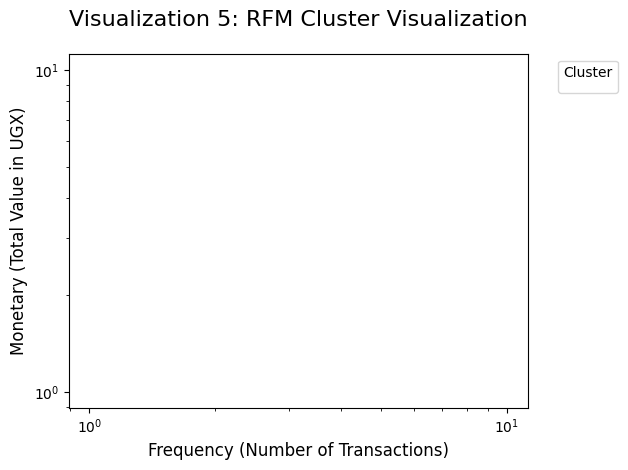

In [69]:
# Create a horizontal bar chart for readability
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Visualization 5: RFM Cluster Visualization', fontsize=16, pad=20)
plt.xlabel('Frequency (Number of Transactions)', fontsize=12)
plt.ylabel('Monetary (Total Value in UGX)', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Log scale for better visibility if values are skewed
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()